# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelPoolAndIdentity
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../../Cholec8k/*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../../Cholec8k/*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPoolAndIdentity.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	#torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerpoolandaidentity_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training 
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 1/100
Train loss: 0.494806, Test loss: 0.3669, Train IoU: 0.3435, Test IoU: 0.4639, Train Dice: 0.5003, Test Dice: 0.6331
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 2/100
Train loss: 0.303100, Test loss: 0.2377, Train IoU: 0.5325, Test IoU: 0.6165, Train Dice: 0.6920, Test Dice: 0.7623
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


[INFO] EPOCH: 3/100
Train loss: 0.204172, Test loss: 0.1791, Train IoU: 0.6569, Test IoU: 0.6966, Train Dice: 0.7909, Test Dice: 0.8209
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:35<00:00,  1.30it/s]


[INFO] EPOCH: 4/100
Train loss: 0.168589, Test loss: 0.1581, Train IoU: 0.7071, Test IoU: 0.7273, Train Dice: 0.8265, Test Dice: 0.8419
Best IoU improved. Model saved.


100%|██████████| 202/202 [03:03<00:00,  1.10it/s]


[INFO] EPOCH: 5/100
Train loss: 0.154512, Test loss: 0.1490, Train IoU: 0.7279, Test IoU: 0.7411, Train Dice: 0.8406, Test Dice: 0.8510
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:26<00:00,  1.37it/s]


[INFO] EPOCH: 6/100
Train loss: 0.146413, Test loss: 0.1421, Train IoU: 0.7401, Test IoU: 0.7515, Train Dice: 0.8487, Test Dice: 0.8579
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:26<00:00,  1.38it/s]


[INFO] EPOCH: 7/100
Train loss: 0.140728, Test loss: 0.1346, Train IoU: 0.7488, Test IoU: 0.7631, Train Dice: 0.8543, Test Dice: 0.8654
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 8/100
Train loss: 0.134018, Test loss: 0.1274, Train IoU: 0.7592, Test IoU: 0.7743, Train Dice: 0.8611, Test Dice: 0.8726
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 9/100
Train loss: 0.128203, Test loss: 0.1242, Train IoU: 0.7682, Test IoU: 0.7793, Train Dice: 0.8669, Test Dice: 0.8758
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 10/100
Train loss: 0.125140, Test loss: 0.1210, Train IoU: 0.7731, Test IoU: 0.7845, Train Dice: 0.8699, Test Dice: 0.8790
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.41it/s]


[INFO] EPOCH: 11/100
Train loss: 0.121724, Test loss: 0.1197, Train IoU: 0.7784, Test IoU: 0.7866, Train Dice: 0.8733, Test Dice: 0.8803
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 12/100
Train loss: 0.119987, Test loss: 0.1163, Train IoU: 0.7812, Test IoU: 0.7920, Train Dice: 0.8751, Test Dice: 0.8837
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:23<00:00,  1.40it/s]


[INFO] EPOCH: 13/100
Train loss: 0.117426, Test loss: 0.1148, Train IoU: 0.7853, Test IoU: 0.7943, Train Dice: 0.8776, Test Dice: 0.8852
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 14/100
Train loss: 0.116610, Test loss: 0.1136, Train IoU: 0.7866, Test IoU: 0.7963, Train Dice: 0.8785, Test Dice: 0.8864
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[INFO] EPOCH: 15/100
Train loss: 0.113918, Test loss: 0.1143, Train IoU: 0.7909, Test IoU: 0.7952, Train Dice: 0.8812, Test Dice: 0.8857


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 16/100
Train loss: 0.113109, Test loss: 0.1126, Train IoU: 0.7922, Test IoU: 0.7979, Train Dice: 0.8820, Test Dice: 0.8874
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 17/100
Train loss: 0.112336, Test loss: 0.1122, Train IoU: 0.7935, Test IoU: 0.7987, Train Dice: 0.8827, Test Dice: 0.8878
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 18/100
Train loss: 0.111139, Test loss: 0.1108, Train IoU: 0.7955, Test IoU: 0.8009, Train Dice: 0.8839, Test Dice: 0.8892
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


[INFO] EPOCH: 19/100
Train loss: 0.110117, Test loss: 0.1113, Train IoU: 0.7970, Test IoU: 0.8000, Train Dice: 0.8850, Test Dice: 0.8887


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 20/100
Train loss: 0.109464, Test loss: 0.1078, Train IoU: 0.7981, Test IoU: 0.8058, Train Dice: 0.8856, Test Dice: 0.8922
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:25<00:00,  1.39it/s]


[INFO] EPOCH: 21/100
Train loss: 0.108362, Test loss: 0.1068, Train IoU: 0.7999, Test IoU: 0.8073, Train Dice: 0.8867, Test Dice: 0.8932
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:18<00:00,  1.46it/s]


[INFO] EPOCH: 22/100
Train loss: 0.108243, Test loss: 0.1063, Train IoU: 0.8001, Test IoU: 0.8081, Train Dice: 0.8868, Test Dice: 0.8937
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 23/100
Train loss: 0.106876, Test loss: 0.1058, Train IoU: 0.8023, Test IoU: 0.8090, Train Dice: 0.8882, Test Dice: 0.8942
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 24/100
Train loss: 0.105565, Test loss: 0.1045, Train IoU: 0.8045, Test IoU: 0.8111, Train Dice: 0.8895, Test Dice: 0.8955
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.41it/s]


[INFO] EPOCH: 25/100
Train loss: 0.103768, Test loss: 0.1020, Train IoU: 0.8074, Test IoU: 0.8152, Train Dice: 0.8913, Test Dice: 0.8980
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 26/100
Train loss: 0.101665, Test loss: 0.0974, Train IoU: 0.8108, Test IoU: 0.8226, Train Dice: 0.8934, Test Dice: 0.9026
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 27/100
Train loss: 0.096554, Test loss: 0.0898, Train IoU: 0.8192, Test IoU: 0.8354, Train Dice: 0.8985, Test Dice: 0.9102
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 28/100
Train loss: 0.092629, Test loss: 0.0922, Train IoU: 0.8257, Test IoU: 0.8313, Train Dice: 0.9024, Test Dice: 0.9078


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 29/100
Train loss: 0.090624, Test loss: 0.0896, Train IoU: 0.8291, Test IoU: 0.8357, Train Dice: 0.9044, Test Dice: 0.9104
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 30/100
Train loss: 0.088574, Test loss: 0.0865, Train IoU: 0.8325, Test IoU: 0.8409, Train Dice: 0.9065, Test Dice: 0.9135
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:20<00:00,  1.43it/s]


[INFO] EPOCH: 31/100
Train loss: 0.087845, Test loss: 0.0847, Train IoU: 0.8338, Test IoU: 0.8439, Train Dice: 0.9072, Test Dice: 0.9153
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 32/100
Train loss: 0.086222, Test loss: 0.0833, Train IoU: 0.8365, Test IoU: 0.8463, Train Dice: 0.9089, Test Dice: 0.9167
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 33/100
Train loss: 0.084346, Test loss: 0.0820, Train IoU: 0.8397, Test IoU: 0.8485, Train Dice: 0.9107, Test Dice: 0.9180
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 34/100
Train loss: 0.084081, Test loss: 0.0817, Train IoU: 0.8401, Test IoU: 0.8490, Train Dice: 0.9110, Test Dice: 0.9183
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 35/100
Train loss: 0.082858, Test loss: 0.0808, Train IoU: 0.8422, Test IoU: 0.8506, Train Dice: 0.9122, Test Dice: 0.9192
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 36/100
Train loss: 0.082584, Test loss: 0.0796, Train IoU: 0.8427, Test IoU: 0.8527, Train Dice: 0.9125, Test Dice: 0.9204
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.41it/s]


[INFO] EPOCH: 37/100
Train loss: 0.082317, Test loss: 0.0785, Train IoU: 0.8431, Test IoU: 0.8545, Train Dice: 0.9128, Test Dice: 0.9215
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 38/100
Train loss: 0.081118, Test loss: 0.0792, Train IoU: 0.8452, Test IoU: 0.8534, Train Dice: 0.9140, Test Dice: 0.9208


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[INFO] EPOCH: 39/100
Train loss: 0.080821, Test loss: 0.0787, Train IoU: 0.8457, Test IoU: 0.8543, Train Dice: 0.9143, Test Dice: 0.9213


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 40/100
Train loss: 0.080239, Test loss: 0.0769, Train IoU: 0.8467, Test IoU: 0.8574, Train Dice: 0.9148, Test Dice: 0.9231
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 41/100
Train loss: 0.079677, Test loss: 0.0766, Train IoU: 0.8476, Test IoU: 0.8578, Train Dice: 0.9154, Test Dice: 0.9234
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 42/100
Train loss: 0.079310, Test loss: 0.0775, Train IoU: 0.8483, Test IoU: 0.8563, Train Dice: 0.9158, Test Dice: 0.9225


100%|██████████| 202/202 [02:20<00:00,  1.43it/s]


[INFO] EPOCH: 43/100
Train loss: 0.079454, Test loss: 0.0766, Train IoU: 0.8480, Test IoU: 0.8579, Train Dice: 0.9156, Test Dice: 0.9234
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 44/100
Train loss: 0.078200, Test loss: 0.0766, Train IoU: 0.8502, Test IoU: 0.8577, Train Dice: 0.9169, Test Dice: 0.9234


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 45/100
Train loss: 0.078180, Test loss: 0.0757, Train IoU: 0.8502, Test IoU: 0.8595, Train Dice: 0.9169, Test Dice: 0.9243
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 46/100
Train loss: 0.077769, Test loss: 0.0765, Train IoU: 0.8509, Test IoU: 0.8579, Train Dice: 0.9173, Test Dice: 0.9235


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 47/100
Train loss: 0.077046, Test loss: 0.0746, Train IoU: 0.8522, Test IoU: 0.8613, Train Dice: 0.9180, Test Dice: 0.9254
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 48/100
Train loss: 0.077068, Test loss: 0.0763, Train IoU: 0.8521, Test IoU: 0.8583, Train Dice: 0.9180, Test Dice: 0.9237


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 49/100
Train loss: 0.077283, Test loss: 0.0749, Train IoU: 0.8517, Test IoU: 0.8607, Train Dice: 0.9178, Test Dice: 0.9251


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 50/100
Train loss: 0.076995, Test loss: 0.0748, Train IoU: 0.8522, Test IoU: 0.8609, Train Dice: 0.9181, Test Dice: 0.9252


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 51/100
Train loss: 0.076703, Test loss: 0.0746, Train IoU: 0.8528, Test IoU: 0.8613, Train Dice: 0.9184, Test Dice: 0.9254


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 52/100
Train loss: 0.076492, Test loss: 0.0744, Train IoU: 0.8531, Test IoU: 0.8616, Train Dice: 0.9186, Test Dice: 0.9256
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 53/100
Train loss: 0.076151, Test loss: 0.0733, Train IoU: 0.8537, Test IoU: 0.8634, Train Dice: 0.9189, Test Dice: 0.9267
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 54/100
Train loss: 0.075606, Test loss: 0.0736, Train IoU: 0.8546, Test IoU: 0.8629, Train Dice: 0.9195, Test Dice: 0.9264


100%|██████████| 202/202 [02:20<00:00,  1.43it/s]


[INFO] EPOCH: 55/100
Train loss: 0.075466, Test loss: 0.0732, Train IoU: 0.8549, Test IoU: 0.8638, Train Dice: 0.9196, Test Dice: 0.9268
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 56/100
Train loss: 0.075626, Test loss: 0.0727, Train IoU: 0.8546, Test IoU: 0.8645, Train Dice: 0.9194, Test Dice: 0.9273
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 57/100
Train loss: 0.075284, Test loss: 0.0745, Train IoU: 0.8552, Test IoU: 0.8614, Train Dice: 0.9198, Test Dice: 0.9255


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 58/100
Train loss: 0.075028, Test loss: 0.0721, Train IoU: 0.8556, Test IoU: 0.8656, Train Dice: 0.9200, Test Dice: 0.9279
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:20<00:00,  1.44it/s]


[INFO] EPOCH: 59/100
Train loss: 0.074929, Test loss: 0.0733, Train IoU: 0.8558, Test IoU: 0.8636, Train Dice: 0.9201, Test Dice: 0.9267


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 60/100
Train loss: 0.074707, Test loss: 0.0721, Train IoU: 0.8562, Test IoU: 0.8656, Train Dice: 0.9204, Test Dice: 0.9279


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[INFO] EPOCH: 61/100
Train loss: 0.074754, Test loss: 0.0720, Train IoU: 0.8561, Test IoU: 0.8658, Train Dice: 0.9203, Test Dice: 0.9280
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 62/100
Train loss: 0.074535, Test loss: 0.0739, Train IoU: 0.8565, Test IoU: 0.8624, Train Dice: 0.9205, Test Dice: 0.9261


100%|██████████| 202/202 [02:20<00:00,  1.43it/s]


[INFO] EPOCH: 63/100
Train loss: 0.074443, Test loss: 0.0713, Train IoU: 0.8566, Test IoU: 0.8670, Train Dice: 0.9206, Test Dice: 0.9287
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:15<00:00,  1.49it/s]


[INFO] EPOCH: 64/100
Train loss: 0.073833, Test loss: 0.0712, Train IoU: 0.8577, Test IoU: 0.8672, Train Dice: 0.9212, Test Dice: 0.9288
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 65/100
Train loss: 0.073861, Test loss: 0.0724, Train IoU: 0.8577, Test IoU: 0.8651, Train Dice: 0.9212, Test Dice: 0.9276


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 66/100
Train loss: 0.073840, Test loss: 0.0725, Train IoU: 0.8577, Test IoU: 0.8649, Train Dice: 0.9212, Test Dice: 0.9275


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 67/100
Train loss: 0.073227, Test loss: 0.0712, Train IoU: 0.8588, Test IoU: 0.8671, Train Dice: 0.9218, Test Dice: 0.9288


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 68/100
Train loss: 0.073130, Test loss: 0.0721, Train IoU: 0.8589, Test IoU: 0.8656, Train Dice: 0.9219, Test Dice: 0.9279


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 69/100
Train loss: 0.072987, Test loss: 0.0717, Train IoU: 0.8592, Test IoU: 0.8663, Train Dice: 0.9221, Test Dice: 0.9283


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[INFO] EPOCH: 70/100
Train loss: 0.072913, Test loss: 0.0712, Train IoU: 0.8593, Test IoU: 0.8671, Train Dice: 0.9222, Test Dice: 0.9288


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[INFO] EPOCH: 71/100
Train loss: 0.072539, Test loss: 0.0713, Train IoU: 0.8600, Test IoU: 0.8670, Train Dice: 0.9225, Test Dice: 0.9287


100%|██████████| 202/202 [02:18<00:00,  1.46it/s]


[INFO] EPOCH: 72/100
Train loss: 0.072740, Test loss: 0.0710, Train IoU: 0.8596, Test IoU: 0.8675, Train Dice: 0.9223, Test Dice: 0.9290
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


[INFO] EPOCH: 73/100
Train loss: 0.072250, Test loss: 0.0714, Train IoU: 0.8605, Test IoU: 0.8668, Train Dice: 0.9228, Test Dice: 0.9286


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 74/100
Train loss: 0.072751, Test loss: 0.0708, Train IoU: 0.8596, Test IoU: 0.8679, Train Dice: 0.9223, Test Dice: 0.9292
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 75/100
Train loss: 0.072147, Test loss: 0.0716, Train IoU: 0.8606, Test IoU: 0.8665, Train Dice: 0.9229, Test Dice: 0.9284


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 76/100
Train loss: 0.071969, Test loss: 0.0708, Train IoU: 0.8609, Test IoU: 0.8679, Train Dice: 0.9231, Test Dice: 0.9292


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 77/100
Train loss: 0.071678, Test loss: 0.0704, Train IoU: 0.8614, Test IoU: 0.8687, Train Dice: 0.9234, Test Dice: 0.9296
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:19<00:00,  1.44it/s]


[INFO] EPOCH: 78/100
Train loss: 0.071898, Test loss: 0.0694, Train IoU: 0.8610, Test IoU: 0.8703, Train Dice: 0.9232, Test Dice: 0.9306
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[INFO] EPOCH: 79/100
Train loss: 0.071907, Test loss: 0.0703, Train IoU: 0.8611, Test IoU: 0.8687, Train Dice: 0.9232, Test Dice: 0.9297


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 80/100
Train loss: 0.071579, Test loss: 0.0710, Train IoU: 0.8616, Test IoU: 0.8675, Train Dice: 0.9235, Test Dice: 0.9290


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 81/100
Train loss: 0.071763, Test loss: 0.0695, Train IoU: 0.8613, Test IoU: 0.8701, Train Dice: 0.9233, Test Dice: 0.9305


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 82/100
Train loss: 0.071311, Test loss: 0.0692, Train IoU: 0.8621, Test IoU: 0.8706, Train Dice: 0.9238, Test Dice: 0.9308
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 83/100
Train loss: 0.071331, Test loss: 0.0694, Train IoU: 0.8620, Test IoU: 0.8703, Train Dice: 0.9237, Test Dice: 0.9306


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 84/100
Train loss: 0.070895, Test loss: 0.0695, Train IoU: 0.8628, Test IoU: 0.8701, Train Dice: 0.9242, Test Dice: 0.9305


100%|██████████| 202/202 [02:22<00:00,  1.41it/s]


[INFO] EPOCH: 85/100
Train loss: 0.071018, Test loss: 0.0686, Train IoU: 0.8626, Test IoU: 0.8718, Train Dice: 0.9241, Test Dice: 0.9314
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.47it/s]


[INFO] EPOCH: 86/100
Train loss: 0.070813, Test loss: 0.0709, Train IoU: 0.8629, Test IoU: 0.8678, Train Dice: 0.9243, Test Dice: 0.9291


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 87/100
Train loss: 0.071072, Test loss: 0.0695, Train IoU: 0.8625, Test IoU: 0.8701, Train Dice: 0.9240, Test Dice: 0.9305


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 88/100
Train loss: 0.070835, Test loss: 0.0695, Train IoU: 0.8629, Test IoU: 0.8701, Train Dice: 0.9242, Test Dice: 0.9305


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 89/100
Train loss: 0.070525, Test loss: 0.0695, Train IoU: 0.8635, Test IoU: 0.8702, Train Dice: 0.9245, Test Dice: 0.9305


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 90/100
Train loss: 0.070326, Test loss: 0.0688, Train IoU: 0.8638, Test IoU: 0.8713, Train Dice: 0.9247, Test Dice: 0.9312


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 91/100
Train loss: 0.070437, Test loss: 0.0680, Train IoU: 0.8636, Test IoU: 0.8728, Train Dice: 0.9246, Test Dice: 0.9320
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 92/100
Train loss: 0.070262, Test loss: 0.0682, Train IoU: 0.8639, Test IoU: 0.8723, Train Dice: 0.9248, Test Dice: 0.9318


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


[INFO] EPOCH: 93/100
Train loss: 0.069978, Test loss: 0.0690, Train IoU: 0.8644, Test IoU: 0.8710, Train Dice: 0.9251, Test Dice: 0.9310


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 94/100
Train loss: 0.070382, Test loss: 0.0688, Train IoU: 0.8637, Test IoU: 0.8713, Train Dice: 0.9247, Test Dice: 0.9312


100%|██████████| 202/202 [02:21<00:00,  1.42it/s]


[INFO] EPOCH: 95/100
Train loss: 0.070088, Test loss: 0.0686, Train IoU: 0.8642, Test IoU: 0.8718, Train Dice: 0.9250, Test Dice: 0.9314


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 96/100
Train loss: 0.070199, Test loss: 0.0684, Train IoU: 0.8640, Test IoU: 0.8722, Train Dice: 0.9249, Test Dice: 0.9316


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


[INFO] EPOCH: 97/100
Train loss: 0.070308, Test loss: 0.0680, Train IoU: 0.8638, Test IoU: 0.8728, Train Dice: 0.9248, Test Dice: 0.9320


100%|██████████| 202/202 [02:17<00:00,  1.47it/s]


[INFO] EPOCH: 98/100
Train loss: 0.069873, Test loss: 0.0686, Train IoU: 0.8646, Test IoU: 0.8717, Train Dice: 0.9252, Test Dice: 0.9314


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


[INFO] EPOCH: 99/100
Train loss: 0.069395, Test loss: 0.0672, Train IoU: 0.8654, Test IoU: 0.8741, Train Dice: 0.9257, Test Dice: 0.9328
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:16<00:00,  1.48it/s]


[INFO] EPOCH: 100/100
Train loss: 0.069533, Test loss: 0.0685, Train IoU: 0.8652, Test IoU: 0.8719, Train Dice: 0.9255, Test Dice: 0.9315
[INFO] total time taken to train the model: 15950.51s
Best IoU is: 0.87415


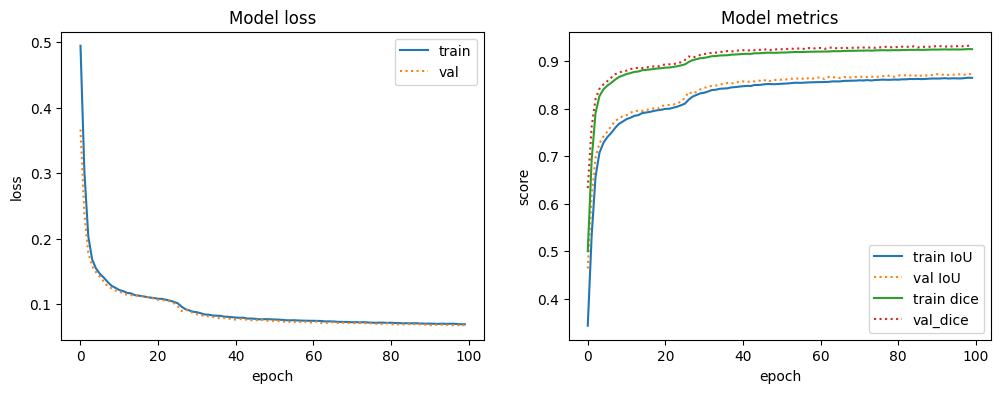

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

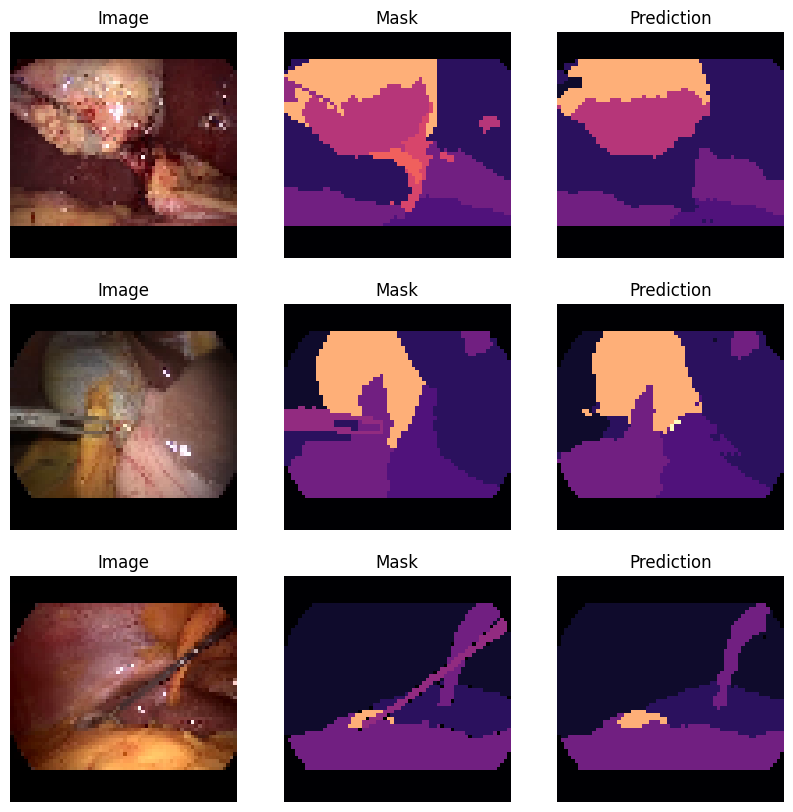

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota